# Multi-Task Observation Using Satellite Imagery & Kitchen Sinks ("MOSAIKS")

Combining satellite imagery with machine learning (SIML) has the potential to address global challenges by remotely estimating socioeconomic and environmental conditions in data-poor regions, yet the resource requirements of SIML limit its accessibility and use. The mission of MOSAIKS is to make SIML more accessible by making the process simpler and easier. Using MOSAIKS, you can make predictions in areas of interest in a few steps:

1. Download MOSAIKS features from our [API](https://siml.berkeley.edu/) for the areas where you have labels

2. Merge the features spatially with your labels

3. Run a regression of your labels on the MOSAIKS features

4. Make predictions and evaluate performance

This notebook walks through a simple example of using MOSAIKS to predict treecover or population in California. It is designed for **Python users**. If you prefer to do this in R, please refer to `MOSAIKS_API_Demo_for_R.ipynb`

In [1]:
#import libraries
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.cm
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#set up working directory
input_dir = '/shares/maps100/data/mosaiks_api/'
#set label filename (can also be switched to 'california_population.csv')
label_filename = 'california_treecover.csv'

# 1. Prepare features and label data

## 1a. Load and inspect your label data

To use MOSAIKS, users must obtain labels, or "ground truth" measurements, of the variable that they would like to remotely sense. Conceptually, these labels enable the relationship between the imagery and the outcome variable to be learned in the regression step. 

To be able to query the API for the features that will spatially match with the labels, users need to calculate the spatial mapping between the label data and the MOSAIKS grid, which has 0.01 x 0.01 degree latitude-longitude resolution. For labels that are finer resolution than the MOSAIKS grid, users can aggregate labels to make a single value for each grid tile. For labels that are coarser resolution than the MOSAIKS grid, users can query the API for features from all of the MOSAIKS grid tiles that intersect spatially with the label data, and then average feature values grouping by label to get a single set of features for each label observation.

In this example, the label we are using is a sample of treecover data in Northern California from [Hansen et al. (2013)](https://www.science.org/doi/10.1126/science.1244693). Because the raw ground truth data is at 30m x 30m resolution, we averaged the treecover fraction data over each MOSAIKS grid tile. As shown below, each row in the label data represents a unique grid cell, with the first two columns displaying latitude and longitude coordinates, and the third column representing our labeled data (fraction of treecover).

In [3]:
#load and inspect label 
label = pd.read_csv(input_dir + label_filename)

label.head(5)

,lon,lat,treecover
0,-117.095,32.595,0.299383
1,-116.995,32.595,0.423611
2,-116.895,32.595,2.600309
3,-116.795,32.595,8.908951
4,-116.695,32.595,6.294753


## 1b. Query and download MOSAIKS features from the API for areas where you have labels

To obtain features for the treecover labels, we upload our set of desired latitude and longitude coordinates to the MOSAIKS API. This can be done by uploading our label file via the File Query function. 

For a step-by-step guide on how to use File Query on the API, **please click [here](https://www.globalpolicy.science/mosaiks-api-filequery).**

Note that during the process of querying, any input latitude and longitude coordinates that do not fall exactly on the API's 0.01 x 0.01 latitude x longitude global grid are allocated to the nearest point. 

## 1c. Load and inspect features 

After downloading our desired features from the API, we load and inspect the contents. Notice that each row represents a unique grid cell located in California, with the first two columns representing latitude and longitude coordinates, and subsequent columns representing K features (presently, K = 4000 features).

In [4]:
#load and inspect features
features = pd.read_csv(input_dir + 'Mosaiks_features.csv')

features.head(5)

,Lat,Lon,,.1,.2,.3,.4,.5,.6,.7,...,.3990,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999
0,33.795,-118.095,0.293148,0.743830,0.153809,0.261851,0.430293,0.707786,0.160360,0.339178,...,0.673799,0.428728,1.082386,0.702387,0.545574,1.435626,3.175371,0.864945,0.941109,0.205001
1,33.895,-118.095,0.307815,0.785287,0.175533,0.300142,0.476278,0.898717,0.156768,0.378405,...,0.802807,0.485670,1.109535,0.854792,0.629842,1.786553,3.468618,0.976709,1.152711,0.210576
2,33.995,-118.095,0.246214,0.558473,0.109746,0.309205,0.363427,0.613274,0.130255,0.265698,...,0.541986,0.296731,0.779118,0.601629,0.502601,1.315237,2.126835,0.770363,0.868011,0.161266
3,34.095,-118.095,0.365053,0.934182,0.257661,0.258698,0.555476,1.200685,0.245323,0.662565,...,1.129115,0.840078,1.800402,1.377028,0.956905,2.138829,4.798244,1.336587,1.334553,0.455701
4,34.195,-118.095,0.098637,0.196328,0.035801,0.054851,0.117285,0.325636,0.095265,0.126930,...,0.180862,0.073689,0.224960,0.245193,0.161819,0.507757,0.793643,0.283706,0.360151,0.049453


# 2. Merge features spatially with label

Here, we merge our downloaded features ("X") with our label ("y") based on the location of grid cells. This results in a single dataset with a vector of MOSAIKS features associated with each label observation. Each row in this dataset represents a label and features for a given 0.01 x 0.01 grid cell. 

In [5]:
#load label
label = pd.read_csv(input_dir + label_filename)

#merge features with label
df = pd.merge(label, features, left_on=['lat','lon'], right_on=['Lat', 'Lon'], how='inner')
#drop NAs
df = df.dropna()

df.head(5)

,lon,lat,treecover,Lat,Lon,,.1,.2,.3,.4,...,.3990,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999
0,-117.095,32.595,0.299383,32.595,-117.095,0.206771,0.583884,0.071545,0.504325,0.315606,...,0.263436,0.140564,0.550522,0.403601,0.261818,0.858177,1.447712,0.521858,0.803021,0.066284
1,-116.995,32.595,0.423611,32.595,-116.995,0.131966,0.364529,0.032098,0.322159,0.195603,...,0.200277,0.067518,0.259101,0.215133,0.194859,0.733979,0.986229,0.379037,0.669029,0.024990
2,-116.895,32.595,2.600309,32.595,-116.895,0.059688,0.205665,0.006498,0.248024,0.090195,...,0.089480,0.008073,0.040318,0.050293,0.063859,0.577365,0.400842,0.226223,0.389460,0.003479
3,-116.795,32.595,8.908951,32.595,-116.795,0.129995,0.371161,0.023103,0.342697,0.196478,...,0.201860,0.028492,0.131370,0.116786,0.134230,0.834378,0.866134,0.430470,0.537669,0.012926
4,-116.695,32.595,6.294753,32.595,-116.695,0.238617,0.637265,0.061696,0.471548,0.353878,...,0.413256,0.120348,0.396702,0.286788,0.315141,1.265146,1.641834,0.766399,0.842222,0.068887


# 3. Run a ridge regression of label on the MOSAIKS features

This step learns how the visual information in the imagery, as captured by the features, relates to the labels. 

Before performing a ridge regression, we first split our data into train (80%) and test (20%). We will estimate the models on the train set and then evaluate predictions in the test set. This separation of train and test set is important to address issues related to overfitting. 

In [6]:
#assign variables
data = df.values
X, y = data[:, 3:], data[:,2]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

#save test set lat/lons for later
plotting_coords = X_test[:,0:2]

#remove lat/lons columns
X_train = X_train[:,2:]
X_test = X_test[:,2:]

Within our training dataset, we choose the penalization parameter in the ridge regression via k-fold cross-validation (here, k=5).

In [7]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
# define model
model = RidgeCV(alphas=[0.001, 0.01,1,10], cv=cv) #alphas here refer to lambda values to try
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 1.000000


# 4. Make predictions and evaluate performance

Next, we use the trained model to make predictions in the test set.

In [8]:
#predict model
y_pred = model.predict(X_test)

We can then evaluate performance in the test set by comparing predictions to the label data.We can then evaluate performance in the test set by comparing predictions to the label data.

In [9]:
#get R^2 from true and predicted values
print('r2: %f' % r2_score(y_test,y_pred))

r2: 0.878877


We can also make a scatter plot of labeled data against predictions.

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Observed')]

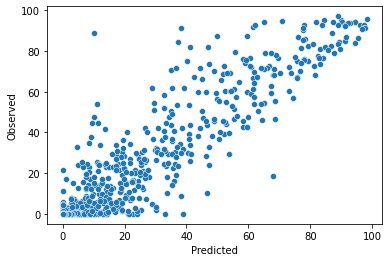

In [10]:
#clip bounds so min value = 0 because we know that treecover cannot be below zero. 
y_pred[y_pred<0] = 0

#scatterplot
ax = sns.scatterplot(x = y_pred, y = y_test)
ax.set(xlabel='Predicted', ylabel='Observed')

Finally, we can compare the spatial distribution of label (i.e. observed) values with predicted values.

In [11]:
#merge lat/lons with test and predicted values
map_plot = pd.DataFrame(plotting_coords, 
                        columns = ['Latitude', 'Longitude'])
map_plot['predicted'] = y_pred
map_plot['observed'] = y_test

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

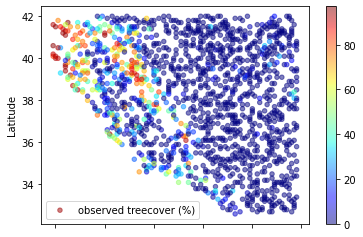

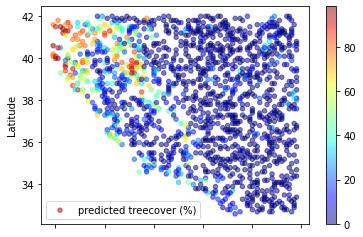

In [12]:
#plot observed 
map_plot.plot(kind="scatter", x="Longitude", y="Latitude", 
    c=map_plot['observed'], label="observed treecover (%)",
    cmap=matplotlib.cm.get_cmap("jet"),
    colorbar=True, alpha=0.5,
)

#plot predicted 
map_plot.plot(kind="scatter", x="Longitude", y="Latitude", 
    c=map_plot['predicted'], label="predicted treecover (%)",
    cmap=matplotlib.cm.get_cmap("jet"),
    colorbar=True, alpha=0.5, 
)